In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

gamma = 50
alpha = 1e6

# defining the Lennard jones potential
def v(x):
    return 4*(1/x**12 - 1/x**6)

# internal part of the Schrodinger eqn, in the Numerov general form y"(t) = g(t)y
def g(x, ek):
    return (gamma**2 * abs(v(x) - ek)) 

def g_for_SE(x, ek, phi):
    return (gamma**2 * (v(x) - ek))** phi

def returnCTPs(ek):
    #Calculating the CTPs, root_scalar returns object with execulation results, unpacking needed for actual root
    ctp_left = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.0, x1=1.0 + 1e-4)
    ctp_right = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.25, x1=1.25 + 1e-4)

    xa = ctp_left.root
    xb = ctp_right.root
    
    return xa,xb

def return_limits_for_E(ek):
    xa, xb = returnCTPs(ek)
    
    xs = root_scalar(
            lambda x: np.sqrt(g(x,ek)) * (xa - x) - np.log(alpha),
            bracket=[0.1,3],
            method='bisect',
        )
        # applying the same for end limit
        # func: sqrt{g(xe)} (xe-xb) ln A
    xe = root_scalar(
            lambda x: np.sqrt(g(x, ek)) * (x - xb) - np.log(alpha),
            bracket=[1,10],
            method='bisect',
        )
    xs = xs.root #unpacking the root_scalar object
    xe = xe.root
    return xs,xe

# Define the Stormer-Verlet function
def stormer_verlet(f, phi0, phi1, h, t):
    """
    Implements the Stormer-Verlet algorithm for solving second-order ODEs.

    Parameters:
    - f: Function to compute the second derivative, f(t, y)
    - phi0: Initial val of the wavefunc
    - phi1: value at second position
    - t_array: Array of time points
    - dt: Time step size

    Returns:
    - y_values: Array of positions at each time step
    """
    # Number of time steps
    n_steps = len(t)

    # Initialize the array to store solutions
    y = np.zeros(n_steps)
    y[0] = phi0  # Initial values, provided as 0 and 1 for the start values
    y[1] = phi1 
    
    v = np.zeros_like(t)
    v[0] = 0

    # Perform the Stormer-Verlet iteration
    for n in range(1, n_steps - 1): 
        y[n + 1] = 2 * y[n] - y[n - 1] + f(t[n], y[n]) * h**2
        # Velocity update (central difference)
        v[n] = (y[n+1] - y[n-1]) / (2 * h)
    # Estimate final velocity
    v[-1] = (y[-1] - y[-2]) / h

    return y

nodes: 0, e: -0.5
nodes: 0, e: -0.25
nodes: 0, e: -0.125
nodes: 0, e: -0.0625
nodes: 0, e: -0.03125
nodes: 0, e: -0.015625
nodes: 0, e: -0.0078125
nodes: 0, e: -0.00390625
nodes: 0, e: -0.001953125


/var/folders/39/cj8j0cjs0f112nt6gsqn4mgr0000gn/T/ipykernel_64543/1910725713.py:17: RuntimeWarning: invalid value encountered in scalar power
  return (gamma**2 * (v(x) - ek))** phi


ValueError: f(a) and f(b) must have different signs

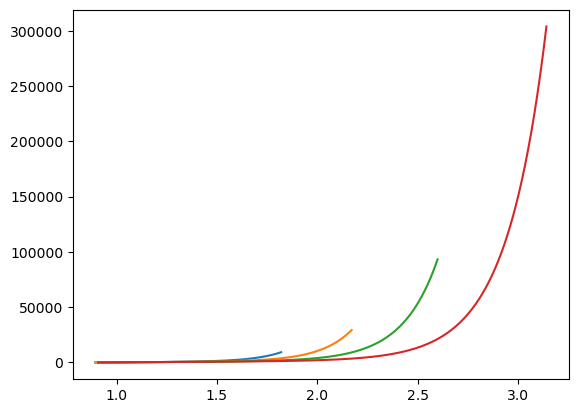

In [26]:
# defining the x-grid
dx = 0.001 
x = np.arange(0.99, 3, dx)
vx = [v(i) for i in x ]


k = 5

e_upper = 0 # bisection limits
e_lower = -1.0  

iter = 1

while iter <= 10:
    e_mid = (e_upper + e_lower)/2
    
    # making calculations for current value of e_mid
    xs, xe = return_limits_for_E(e_mid)
    
    x_range = np.arange(xs-dx, xe+dx, dx)
    
    phi = stormer_verlet(
            lambda phi, x: g_for_SE(x, e_mid, phi),
            0,
            1,
            dx,
            x_range
        )
    
    nodes = 0
    for i in range(0, phi.size-1):
        if phi[i]*phi[i+1] < 0:
            nodes = nodes + 1      
    
    if nodes > k:
        e_upper = e_mid
    else:
        e_lower = e_mid
    
    print(f"nodes: {nodes}, e: {e_mid}")
    
    plt.plot(x_range,phi,label = f"{iter}")


    iter = iter + 1
plt.yscale("log")
plt.legend()